## Dog Breed Classification

In this project we will use traditional CNN, CNN with data augmentation and finally transfer Learning by VGG16 model with weights pre-trained on Imagenet to solve the dog breed classification problem

### Load Dataset Files

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.datasets import cifar10, mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Reshape
from keras.layers import Convolution2D, MaxPooling2D, BatchNormalization
from keras.utils import np_utils
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 8)

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


Now, upload the given dataset file shared with you in your google drive and give its path for the below given `project_path` variable. For example, a path is given below according to the file path in our google drive. You need to change this to match the path of yours.

In [0]:
project_path = "/drive/My Drive/AIML/Projects/Dog Breed/"

Run the below code to extract all the images in the train.zip files given in the dataset. We are going to use these images as train and validation sets and their labels in further steps.

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

Repeat the same step for test.zip

In [0]:
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

Repeat the same step for sample_submission.csv.zip

In [0]:
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

Repeat the same step for labels.csv.zip

In [0]:
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

After this process, we will have 4 files - Train folder, test folder and labels.csv and sample_submission.csv as part of your google drive

### Read labels.csv file using pandas

In [0]:
labels = pd.read_csv('labels.csv')

In [9]:
labels.shape

(10222, 2)

In [10]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


### Print the count of each category of Dogs given in the dataset



In [11]:
labels.groupby(by='breed').count()

,id
breed,
affenpinscher,80
afghan_hound,116
african_hunting_dog,86
airedale,107
american_staffordshire_terrier,74
...,...
welsh_springer_spaniel,79
west_highland_white_terrier,81
whippet,95


In [12]:
labels['breed'].unique()

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'borzoi', 'basenji', 'scottish_deerhound',
       'shetland_sheepdog', 'walker_hound', 'maltese_dog',
       'norfolk_terrier', 'african_hunting_dog',
       'wire-haired_fox_terrier', 'redbone', 'lakeland_terrier', 'boxer',
       'doberman', 'otterhound', 'standard_schnauzer',
       'irish_water_spaniel', 'black-and-tan_coonhound', 'cairn',
       'affenpinscher', 'labrador_retriever', 'ibizan_hound',
       'english_setter', 'weimaraner', 'giant_schnauzer', 'groenendael',
       'dhole', 'toy_poodle', 'border_terrier', 'tibetan_terrier',
       'norwegian_elkhound', 'shih-tzu', 'irish_terrier', 'kuvasz',
       'german_shepherd', 'greater_swiss_mountain_dog', 'basset',
       'australian_terrier', 'schipperke', 'rhodesian_ridgeback',
       'irish_setter', 'appenzeller', 'bloodhound', 'samoyed',
       'miniature_schnauzer', 'brittany_spaniel', 'kelpie', 'papillon',
       'borde

### Get one-hot encodings of labels

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
label_encoder = LabelEncoder()

In [15]:
label_encoder.fit(labels['breed'])

LabelEncoder()

In [0]:
labels['breed'] = label_encoder.transform(labels['breed'])

In [17]:
np.unique(labels['breed'])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119])

## Preparing training dataset
1. Write a code which reads each and every id from labels.csv file and loads the corresponding image (in RGB - 128, 128, 3) from the train folder. <br>
2. Create 2 variables <br> 
     a.  x_train - Should have all the images of the dogs from train folder <br>
     b.  y_train - Corresponding label of the dog <br>
<u>Note:</u> The id of the dog images and its corresponding labels are available in labels.csv file   
<u>Hint:</u> Watch the video shared on "Preparing the training dataset" if you face issue on creating the training dataset

In [0]:
from tqdm import tqdm
import cv2

In [19]:
x_train_data = []
y_train_data = []
scale = 128
for f, img in tqdm(labels.values):
  train_img = cv2.imread('./train/{}.jpg'.format(f),1)
  train_img_resize = cv2.resize(train_img, (scale,scale))
  x_train_data.append(train_img_resize)
  y_train_data.append(img)

100%|██████████| 10222/10222 [00:27<00:00, 365.25it/s]


In [0]:
import skimage.io as io
import matplotlib.pyplot as plt

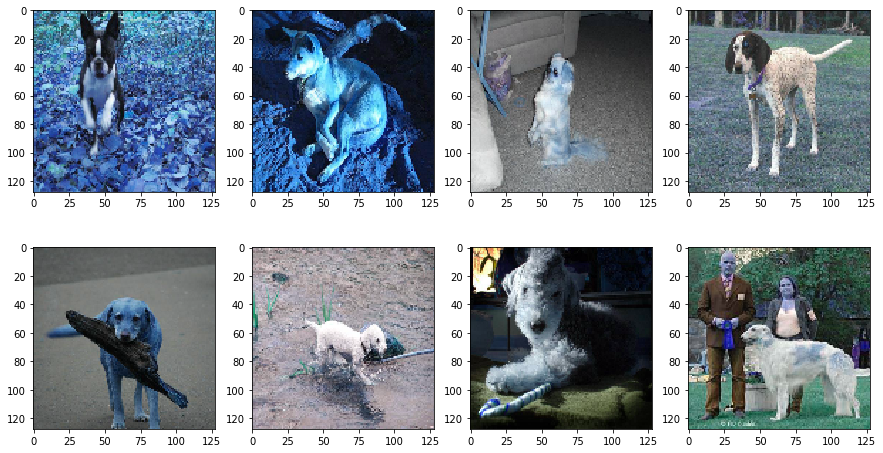

In [21]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_train_data[i])

Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [0]:
x_train_data = np.asarray(x_train_data)

In [0]:
x_train_data = x_train_data/255

In [24]:
x_train_data.shape

(10222, 128, 128, 3)

In [0]:
y_train_data = np_utils.to_categorical(y_train_data, num_classes=120)

In [26]:
y_train_data.shape

(10222, 120)

### Split the training and validation data from `x_train_data` and `y_train_data` obtained from above step

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train, x_validation, y_train, y_validation = train_test_split(x_train_data, y_train_data, test_size=0.3, random_state=42) 

### Loading the test data
Read the id column from the samples_submission.csv and store it in test_img

In [0]:
test_img = pd.read_csv('sample_submission.csv')

In [30]:
test_img.shape

(10357, 121)

Run the below code to load the test image files in x_test_feature

In [31]:
x_test_feature = []
for f in tqdm(test_img['id']): # f for format ,jpg
    img = cv2.imread('./test/{}.jpg'.format(f), 1)
    img_resize = cv2.resize(img, (scale, scale)) 
    x_test_feature.append(img_resize)

100%|██████████| 10357/10357 [00:27<00:00, 371.92it/s]


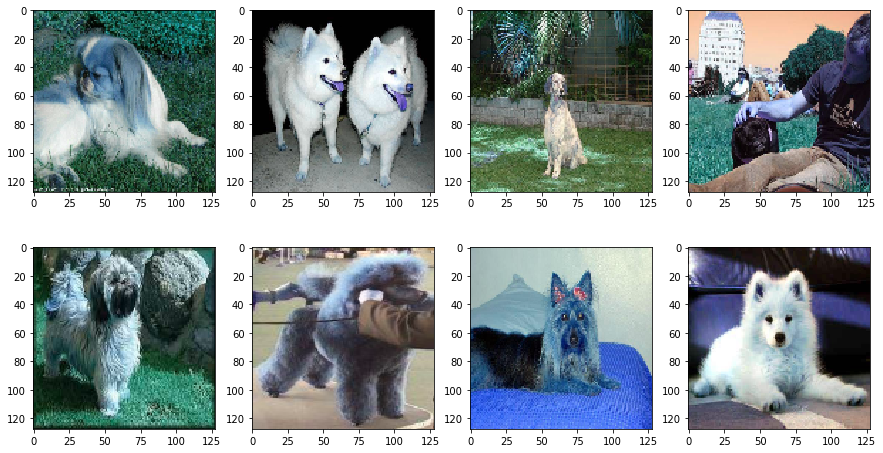

In [32]:
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(x_test_feature[i])

Normalize the test data and convert it into 4 dimensions

In [0]:
x_test_feature = np.asarray(x_test_feature)

In [0]:
x_test_feature = x_test_feature/255

In [35]:
x_test_feature.shape

(10357, 128, 128, 3)

### Build a basic conv neural network with 2 conv layers (kernel sizes - 5 and 3) add layers as mentioned below for classification.

1. Add a Dense layer with 256 neurons with `relu` activation

2. Add a Dense layer with 120 neurons as final layer (as there are 120 classes in the given dataset) with `softmax` activation for classifiaction. 

In [36]:
model = Sequential()

model.add(Convolution2D(16, 5, 5, input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))

model.add(Convolution2D(16, 3, 3, input_shape=(128,128,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

#Add Fully Connected Layer with 128 units and activation function as 'ReLU'
model.add(Dense(256, activation='relu'))
#Final Layer
model.add(Dense(120))
model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), input_shape=(128, 128,...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(128, 128,...)`
  import sys


In [37]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Use batch_size = 128 and epochs = 10 and execute the model

In [0]:
batch_size=128
epochs=10

In [39]:
model.fit(x_train, y_train, batch_size=batch_size,
                    nb_epoch=epochs,
                    validation_data=(x_validation, y_validation))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7155 samples, validate on 3067 samples
Epoch 1/10





7155/7155 [==============================] - 17s 2ms/step - loss: 4.8288 - acc: 0.0105 - val_loss: 4.7770 - val_acc: 0.0166
Epoch 2/10
7155/7155 [==============================] - 3s 399us/step - loss: 4.7213 - acc: 0.0231 - val_loss: 4.6675 - val_acc: 0.0205
Epoch 3/10
7155/7155 [==============================] - 3s 401us/step - loss: 4.4264 - acc: 0.0485 - val_loss: 4.4663 - val_acc: 0.0437
Epoch 4/10
7155/7155 [==============================] - 3s 400us/step - loss: 4.0346 - acc: 0.1010 - val_loss: 4.4885 - val_acc: 0.0476
Epoch 5/10
7155/7155 [==============================] - 3s 399us/step - loss: 3.5599 - acc: 0.1856 - val_loss: 4.6335 - val_acc: 0.0522
Epoch 6/10
7155/7155 [==============================] - 3s 399us/step - loss: 2.8809 - acc: 0.3191 - val_loss: 5.0750 - val_acc: 0.0473
Epoch 7/10
7155/7155 [=============

#The model accuracy is very poor !!!!

### Use Data Augmentation in the above model to see if the accuracy improves


In [0]:
from keras.preprocessing.image import ImageDataGenerator

### Using the above objects, create the image generators with variable names `train_generator` and `val_generator`

You need to use train_datagen.flow() and val_datagen.flow()

In [0]:
train_generator = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=50,  
    width_shift_range=0.02,  
    height_shift_range=0.02,  
    horizontal_flip=True, 
    vertical_flip=True)

In [0]:
train_generator.fit(x_train)

In [0]:
val_generator = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    rotation_range=50,  
    width_shift_range=0.02,  
    height_shift_range=0.02,  
    horizontal_flip=True, 
    vertical_flip=True)

In [0]:
val_generator.fit(x_validation)

### Fit the model using fit_generator() using `train_generator` and `val_generator` from the above step with 10 epochs

In [49]:
model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size),
                    nb_epoch=epochs,validation_data = val_generator.flow(x_validation, y_validation))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., epochs=10)`
  


Epoch 1/10
56/56 [==============================] - 31s 560ms/step - loss: 5.0215 - acc: 0.0233 - val_loss: 4.6807 - val_acc: 0.0225
Epoch 2/10
56/56 [==============================] - 27s 484ms/step - loss: 4.5778 - acc: 0.0303 - val_loss: 4.5752 - val_acc: 0.0316
Epoch 3/10
56/56 [==============================] - 27s 488ms/step - loss: 4.4499 - acc: 0.0404 - val_loss: 4.4948 - val_acc: 0.0398
Epoch 4/10
56/56 [==============================] - 27s 491ms/step - loss: 4.3477 - acc: 0.0507 - val_loss: 4.4979 - val_acc: 0.0372
Epoch 5/10
56/56 [==============================] - 27s 477ms/step - loss: 4.3130 - acc: 0.0506 - val_loss: 4.4299 - val_acc: 0.0339
Epoch 6/10
56/56 [==============================] - 27s 482ms/step - loss: 4.2526 - acc: 0.0599 - val_loss: 4.4335 - val_acc: 0.0427
Epoch 7/10
56/56 [==============================] - 27s 485ms/step - loss: 4.2364 - acc: 0.0674 - val_loss: 4.3952 - val_acc: 0.0440
Epoch 8/10
56/56 [==============================] - 27s 489ms/step - 

# Model accuracy is still poor!!!

### Lets use Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

Use the below code to load VGG16 weights trained on ImageNet

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import models
# Instantiate the model with the pre-trained weights (no top)
base_model= VGG16(weights=(project_path+'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'),
                 include_top=False,input_shape=(128,128,3))

Print the summary of the base_model

In [246]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Add the following classification layers to the imported VGG Model <br>
1. Flatten Layer
2. Dense layer with 1024 neurons with activation as Relu
3. Dense layer with 256 neurons with activation as Relu
4. Dense layer with 120 neurons with activation as Softmax

In [0]:
x = base_model.output
x=Flatten()(x)
x=Dense(1024, activation='relu', name='dense_1')(x)
x=Dense(256, activation='relu', name='dense_2')(x)
predictions=Dense(120, activation='softmax', name='dense_3')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

### Make all the layers in the base_model (VGG16) to be non-trainable

In [0]:
for layer in model.layers:
  if('dense' not in layer.name): #prefix detection to freeze layers which does not have dense
    #Freezing a layer
    layer.trainable = False

### Fit and compile the model with batch_size = 128 and epochs = 10 and execute the model

Try to get training and validation accuracy to be more than 90%

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [253]:
model.fit(x_train, y_train, batch_size=128,
                    nb_epoch=10,validation_data = (x_validation, y_validation))

Train on 7155 samples, validate on 3067 samples
Epoch 1/10
 128/7155 [..............................] - ETA: 7s - loss: 4.7918 - acc: 0.0078

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


7155/7155 [==============================] - 11s 2ms/step - loss: 4.7871 - acc: 0.0103 - val_loss: 4.7864 - val_acc: 0.0114
Epoch 2/10
7155/7155 [==============================] - 10s 1ms/step - loss: 4.7853 - acc: 0.0109 - val_loss: 4.7920 - val_acc: 0.0065
Epoch 3/10
7155/7155 [==============================] - 10s 1ms/step - loss: 4.7848 - acc: 0.0101 - val_loss: 4.7853 - val_acc: 0.0091
Epoch 4/10
7155/7155 [==============================] - 10s 1ms/step - loss: 4.7784 - acc: 0.0115 - val_loss: 4.7744 - val_acc: 0.0104
Epoch 5/10
7155/7155 [==============================] - 10s 1ms/step - loss: 4.7774 - acc: 0.0119 - val_loss: 4.7779 - val_acc: 0.0091
Epoch 6/10
7155/7155 [==============================] - 10s 1ms/step - loss: 4.7418 - acc: 0.0126 - val_loss: 4.7042 - val_acc: 0.0157
Epoch 7/10
7155/7155 [==============================] - 10s 1ms/step - loss: 4.6384 - acc: 0.0166 - val_loss: 4.6346 - val_acc: 0.0186
Epoch 8/10
7155/7155 [==============================] - 10s 1ms/st